In [1]:
# Import-a-ton
import pandas as pd
import sqlite3

# Instacart

## Seting up SQL

In [2]:
connection = sqlite3.connect('./datasets/instacart/sql/instacart.db.sqlite')

## Prodcuts

In [3]:
# Load the products dataset
products = './datasets/instacart/products.csv'
df_product = pd.read_csv(products, encoding = 'utf8')

In [4]:
df_product.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [5]:
# Save it to SQL
df_product.to_sql(name='product',con=connection,if_exists='replace',index=False)

## Orders

In [6]:
# Load the orders dataset
orders = '../data/raw/orders.csv'
df_order = pd.read_csv(orders, encoding = 'utf8')

In [7]:
df_order.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [8]:
# Save it to SQL
df_order.to_sql(name='orders',con=connection,if_exists='replace',index=False)

## Orders and Products

In [9]:
# Load the order_products dataset
order_products = '../data/raw/order_products.csv'
df_main = pd.read_csv(order_products, encoding = 'utf8')

In [10]:
df_main.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [11]:
# Saving to a SQL file
df_main.to_sql(name='main',con=connection,if_exists='replace',index=False)

## SQL power!

Taking only `user_id`, `product_id`, and the `product_name` to form a new DataFrame and then saving it into it's own table (in SQL) and CSV file. 

This is our `groceries` dataset.

In [12]:
sql_query = '''
SELECT orders.user_id, main.product_id, product.product_name 
FROM main
INNER JOIN product ON product.product_id = main.product_id
INNER JOIN orders ON orders.order_id = main.order_id
'''

In [13]:
# This will join them all but it will take a loooong time
groceries = pd.read_sql(sql_query, con=connection)

In [14]:
groceries.head()

,user_id,product_id,product_name
0,202279,33120,Organic Egg Whites
1,202279,28985,Michigan Organic Kale
2,202279,9327,Garlic Powder
3,202279,45918,Coconut Butter
4,202279,30035,Natural Sweetener


In [15]:
groceries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 3 columns):
user_id         int64
product_id      int64
product_name    object
dtypes: int64(2), object(1)
memory usage: 742.4+ MB


In [16]:
# Saving it to SQL
#
# This will also take some time...
groceries.to_sql(name='groceries',con=connection,if_exists='replace',index=False)

In [17]:
# Write to CSV
#
# This will take a longer time, almost as long as the inner join queries
groceries.to_csv('../data/raw/groceries.csv', encoding='utf8')

# Cleaning Instacart for Neo4j

In [13]:
connection = sqlite3.connect('./datasets/instacart/sql/products_temp.db')

In [17]:
sql_query = '''
SELECT products.product_id, products.product_name, products.aisle_id, products.department_id, aisle.aisle, department.department
FROM products
INNER JOIN aisle ON products.aisle_id = aisle.aisle_id
INNER JOIN department ON products.department_id = department.department_id
'''

In [18]:
df = pd.read_sql(sql_query, con=connection)

In [20]:
df.head()

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,2,All-Seasons Salt,104,13,spices seasonings,pantry
2,3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen meals,frozen
4,5,Green Chile Anytime Sauce,5,13,marinades meat preparation,pantry


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 6 columns):
product_id       49688 non-null int64
product_name     49688 non-null object
aisle_id         49688 non-null int64
department_id    49688 non-null int64
aisle            49688 non-null object
department       49688 non-null object
dtypes: int64(3), object(3)
memory usage: 2.3+ MB


In [22]:
df['department'].value_counts()

personal care      6563
snacks             6264
pantry             5371
beverages          4365
frozen             4007
dairy eggs         3449
household          3085
canned goods       2092
dry goods pasta    1858
produce            1684
bakery             1516
deli               1322
missing            1258
international      1139
breakfast          1115
babies             1081
alcohol            1054
pets                972
meat seafood        907
other               548
bulk                 38
Name: department, dtype: int64

In [23]:
# I want to take a look at a few dubious ones
df[df['department']=='international'].head()

,product_id,product_name,aisle_id,department_id,aisle,department
46,47,Onion Flavor Organic Roasted Seaweed Snack,66,6,asian foods,international
69,70,Sweet Cooking Rice Seasoning,66,6,asian foods,international
94,95,Organic Rice Vinegar,66,6,asian foods,international
160,161,Hacho Miso Aged & Fermented Soybeans,66,6,asian foods,international
191,192,Israeli Style Gefilte Fish,33,6,kosher foods,international


In [26]:
df[df['department']=='other'].head()

,product_id,product_name,aisle_id,department_id,aisle,department
85,86,"Camilia, Single Liquid Doses",6,2,other,other
505,506,Arrowroot Powder,6,2,other,other
534,535,Rescue Remedy,6,2,other,other
675,676,Sunset Blush,6,2,other,other
712,713,Pink Moscato California,6,2,other,other


In [27]:
df[df['department']=='bulk'].head()

,product_id,product_name,aisle_id,department_id,aisle,department
502,503,Wild Rice Blend,68,10,bulk grains rice dried goods,bulk
999,1000,Apricots,18,10,bulk dried fruits vegetables,bulk
5160,5161,Dried Mango,18,10,bulk dried fruits vegetables,bulk
6193,6194,Organic Red Kidney Beans,68,10,bulk grains rice dried goods,bulk
6454,6455,Organic Magic Muesli,68,10,bulk grains rice dried goods,bulk


Ok, 'International' and 'other' is good to keep. We can delete a few other departments...

In [57]:
to_delete = ['personal care','household','missing','babies','pets']

In [61]:
df_clean = df[~df['department'].isin(to_delete)].copy()

In [62]:
df_clean.head()

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,2,All-Seasons Salt,104,13,spices seasonings,pantry
2,3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen meals,frozen
4,5,Green Chile Anytime Sauce,5,13,marinades meat preparation,pantry


In [63]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36729 entries, 0 to 49685
Data columns (total 6 columns):
product_id       36729 non-null int64
product_name     36729 non-null object
aisle_id         36729 non-null int64
department_id    36729 non-null int64
aisle            36729 non-null object
department       36729 non-null object
dtypes: int64(3), object(3)
memory usage: 2.0+ MB


In [64]:
df_clean['product_name'].str.contains('"').sum()

54

In [69]:
# Dropping these 54 rows
df_clean = df_clean[~df_clean['product_name'].str.contains('"')]

In [70]:
# Remove all the weird utf-8 stuff
df_clean['product_name'] = df_clean['product_name'].apply(lambda x: x.encode('ascii', 'ignore').decode('ascii').strip())

In [71]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36675 entries, 0 to 49685
Data columns (total 6 columns):
product_id       36675 non-null int64
product_name     36675 non-null object
aisle_id         36675 non-null int64
department_id    36675 non-null int64
aisle            36675 non-null object
department       36675 non-null object
dtypes: int64(3), object(3)
memory usage: 2.0+ MB


In [72]:
# Save to csv
df_clean.to_csv('../data/processed/products_clean.csv', index=False)

In [73]:
df_clean.isnull().sum()

product_id       0
product_name     0
aisle_id         0
department_id    0
aisle            0
department       0
dtype: int64

# Preparing Orders, Products and Users for Neo4j

In [11]:
sql_query = '''
SELECT orders.user_id, main.product_id, orders.order_hour_of_day, COUNT(orders.order_id) AS total_orders
FROM main
INNER JOIN product ON product.product_id = main.product_id
INNER JOIN orders ON orders.order_id = main.order_id
GROUP BY orders.order_id
'''

In [12]:
df = pd.read_sql(sql_query, con=connection)

In [16]:
df.sort_values(by='user_id', inplace=True)

In [17]:
df.head(20)

,user_id,product_id,order_hour_of_day,total_orders
445008,1,30450,12,5
405352,1,13176,15,8
2118491,1,26405,7,5
2396411,1,12427,8,9
2386095,1,26405,8,5
2253888,1,13032,7,6
516695,1,13032,9,5
3164631,1,25133,7,4
2156588,1,12427,16,6
2921151,1,49235,14,6


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214874 entries, 0 to 3214873
Data columns (total 4 columns):
user_id              int64
product_id           int64
order_hour_of_day    int64
total_orders         int64
dtypes: int64(4)
memory usage: 98.1 MB


In [18]:
df.to_csv('../data/processed/users_orders.csv', index=False)

# Averages for order_totals

In [3]:
df.head()

,user_id,product_id,order_hour_of_day,total_orders
0,1,30450,12,5
1,1,13176,15,8
2,1,26405,7,5
3,1,12427,8,9
4,1,26405,8,5


In [5]:
df['total_orders'].describe()

count    3.214874e+06
mean     1.008888e+01
std      7.525398e+00
min      1.000000e+00
25%      5.000000e+00
50%      8.000000e+00
75%      1.400000e+01
max      1.450000e+02
Name: total_orders, dtype: float64

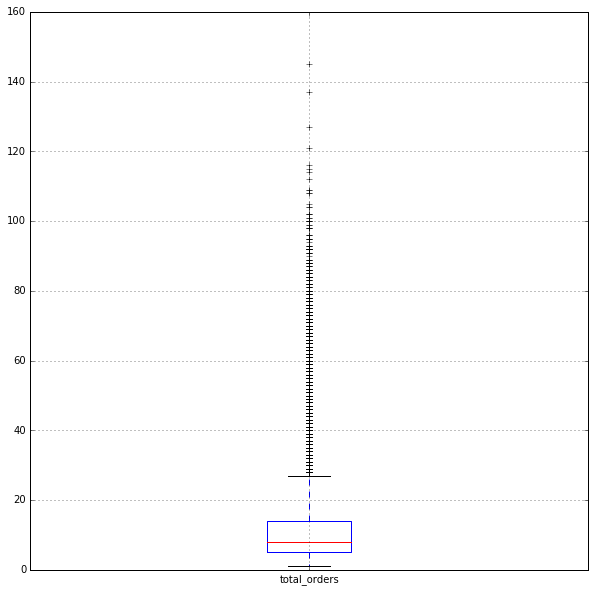

In [8]:
df.boxplot(column='total_orders',figsize=(10,10))